In [2]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


SAMPLE_PATH = "../data/sample/sample_5_percent.parquet"
df = pl.read_parquet(SAMPLE_PATH)

print(f"Dataset Shape: {df.shape}")

Dataset Shape: (407358, 41)


In [3]:
df = df.to_pandas()

In [4]:
X = df.drop(columns=["label", "label_category"])
y = df["label_category"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")



0: Benign
1: DDoS
2: DoS
3: Mirai
4: Recon
5: Spoofing
6: Web_BruteForce


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y, random_state=42
)

In [9]:
xgb = XGBClassifier(
    n_estimators=100,
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)
rfe = RFE(estimator=xgb, n_features_to_select=20, step=1)
rfe.fit(X_train, y_train)

,"estimator estimator: ``Estimator`` instanceA supervised learning estimator with a ``fit`` method that providesinformation about feature importance(e.g. `coef_`, `feature_importances_`).","XGBClassifier...ree=None, ...)"
,"n_features_to_select n_features_to_select: int or float, default=NoneThe number of features to select. If `None`, half of the features areselected. If integer, the parameter is the absolute number of featuresto select. If float between 0 and 1, it is the fraction of features toselect... versionchanged:: 0.24 Added float values for fractions.",20
,"step step: int or float, default=1If greater than or equal to 1, then ``step`` corresponds to the(integer) number of features to remove at each iteration.If within (0.0, 1.0), then ``step`` corresponds to the percentage(rounded down) of features to remove at each iteration.",1
,"verbose verbose: int, default=0Controls verbosity of output.",0
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a `coef_`or `feature_importances_` attributes of estimator.Also accepts a string that specifies an attribute name/pathfor extracting feature importance (implemented with `attrgetter`).For example, give `regressor_.coef_` in case of:class:`~sklearn.compose.TransformedTargetRegressor` or`named_steps.clf.feature_importances_` in case ofclass:`~sklearn.pipeline.Pipeline` with its last step named `clf`.If `callable`, overrides the default feature importance getter.The callable is passed with the fitted estimator and it shouldreturn importance for each feature... versionadded:: 0.24",'auto'
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None



Selected 20 Features:
['Header_Length', 'Protocol Type', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'rst_count', 'TCP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'IAT', 'Number']

 Dropped 19 Features:
['Time_To_Live', 'ece_flag_number', 'cwr_flag_number', 'fin_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'UDP', 'DHCP', 'ARP', 'IGMP', 'IPv', 'LLC', 'Tot size', 'Variance']


/var/folders/n0/5m_fhb1d7xdbhfkz54jbzbnh0000gn/T/ipykernel_26234/3399391653.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=selected_features, palette="viridis")


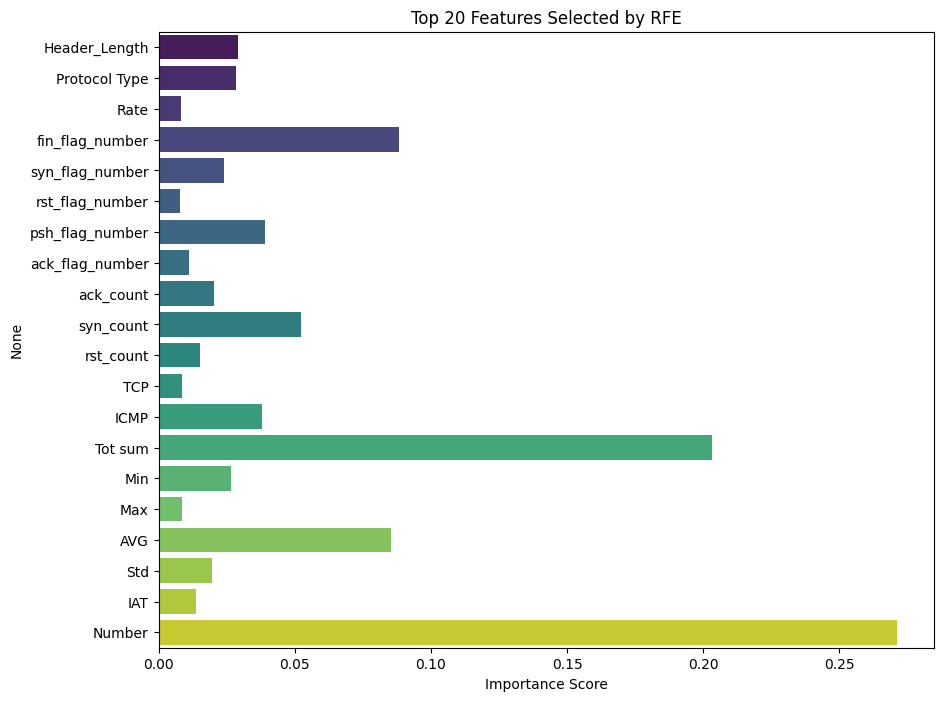

In [10]:
selected_mask = rfe.support_
selected_features = X.columns[selected_mask]
dropped_features = X.columns[~selected_mask]

print(f"\nSelected {len(selected_features)} Features:")
print(list(selected_features))

print(f"\n Dropped {len(dropped_features)} Features:")
print(list(dropped_features))


final_model = rfe.estimator_
importances = final_model.feature_importances_

plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=selected_features, palette="viridis")
plt.title("Top 20 Features Selected by RFE")
plt.xlabel("Importance Score")
plt.show()

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
reduced_df = df[selected_features.tolist() + ["label_category"]]
plot_df = reduced_df.sample(10000, random_state=42)
X = plot_df.drop(columns=["label_category"])
y = plot_df["label_category"]

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

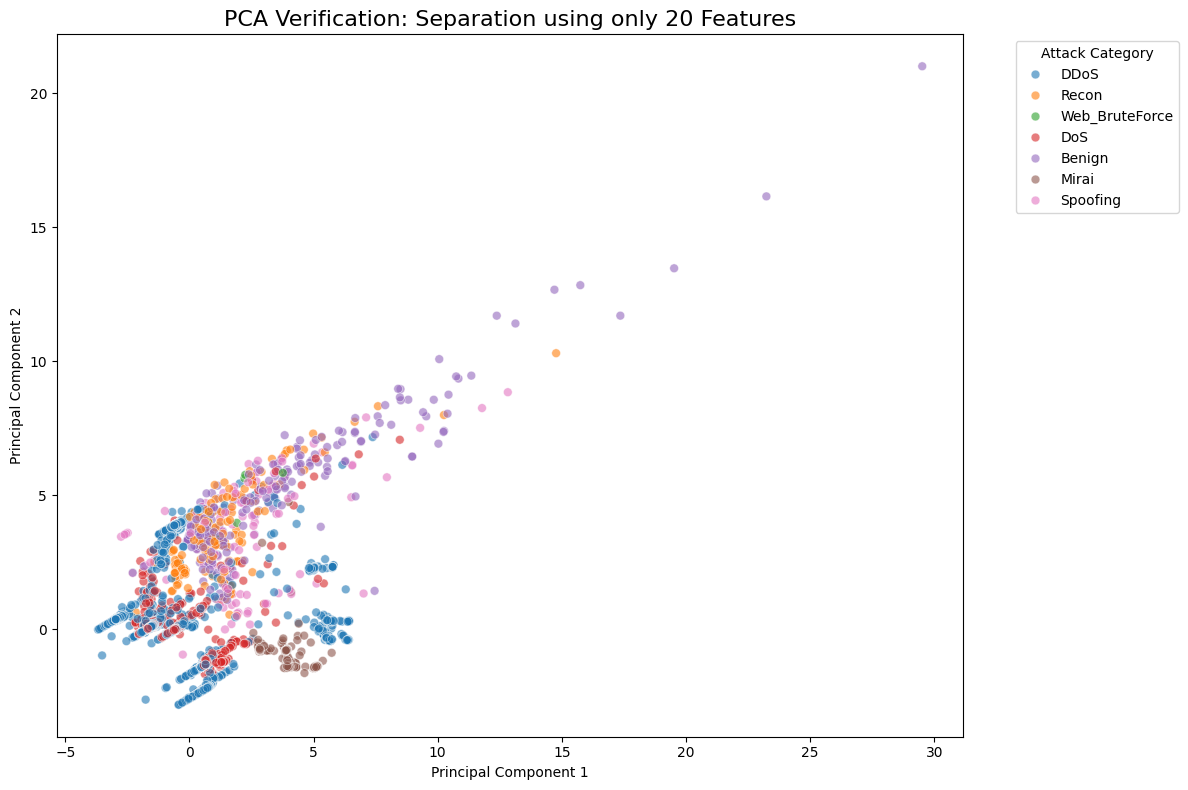

In [19]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1], 
    hue=y, 
    palette="tab10", 
    alpha=0.6,
    s=40 
)
plt.title(f"PCA Verification: Separation using only {len(selected_features)} Features", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Attack Category")
plt.tight_layout()
plt.show()

In [20]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Explained Variance Ratio: [0.2084267 0.1859478]
Total Information Retained: 39.44%
